Instructions: click restart and run all above. Figures will show once the entire notebook has finished running

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib notebook

# Quantifying membrane and cytoplasmic protein from AF-corrected images

After autofluorescence correction, any remaining signal can be attributed to fluorescent protein. At the cell perimeter, this protein will be a combination of cytoplasmic protein and membrane protein, and this distribution will vary around the circumference of the cell in the case of a polarised protein. This is observable in a straightened image of the cortex (see [here](./appendix_rois_and_straightening.ipynb) for discussion of straightening algorithm), in which each position in the x direction represents a cross-section across the cortex at that position:

<IPython.core.display.Javascript object>


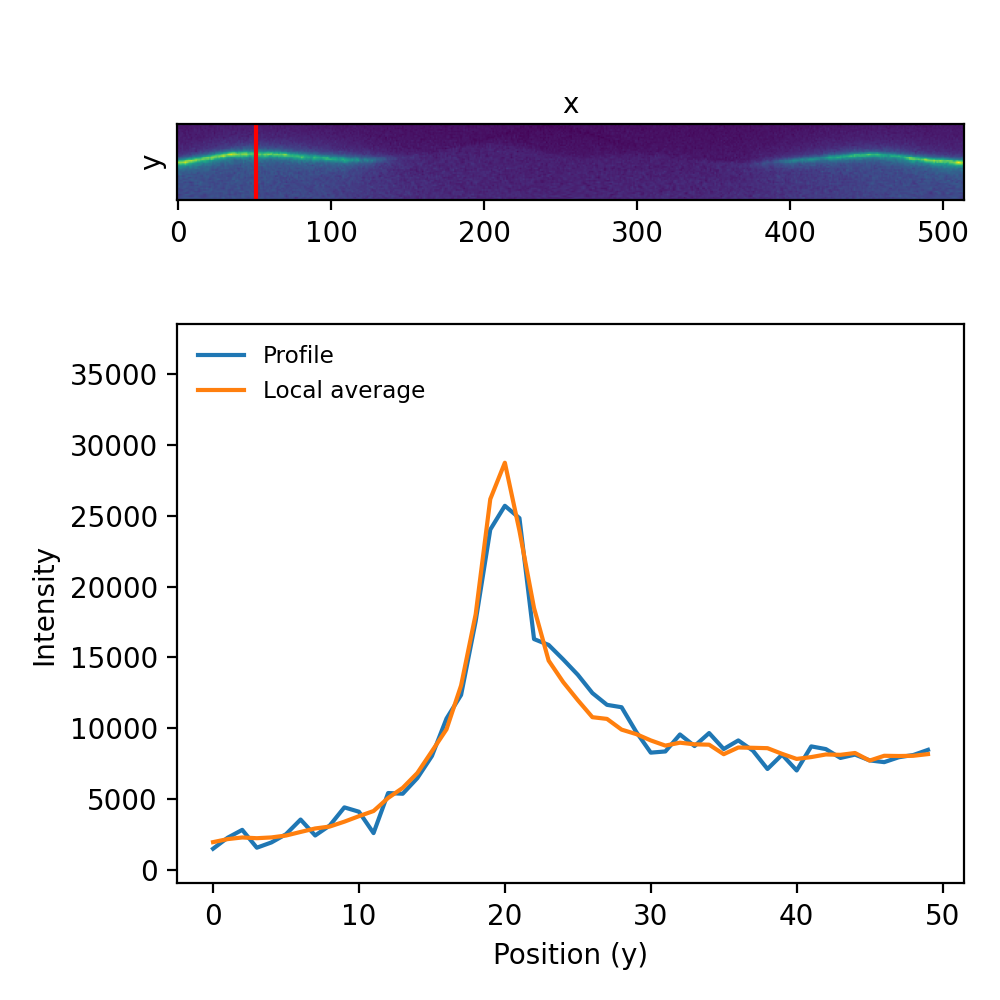

interactive(children=(IntSlider(value=10, description='position', max=513), Output()), _dom_classes=('widget-i…

In [2]:
from membranequant.funcs import load_image, straighten, rolling_ave_2d

# Load data
path = '../test_datasets/dataset2_par2_neon/01/'
img = load_image(path + '/af_corrected.tif')
roi = np.loadtxt(path + '/ROI.txt')

# Straighten, apply rolling average
straight = straighten(img, roi=roi, thickness=50)
straight_filtered = rolling_ave_2d(straight, window=20, periodic=True)

def fig1():
    fig = plt.figure()
    gs = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1:, :])
    ymin, ymax = np.min(straight), np.max(straight)
    @widgets.interact(position=(0, straight.shape[1]-1, 1))
    def update(position=10):

        ax1.clear()
        ax1.imshow(straight)
        ax1.axvline(position, c='r')
        ax1.set_yticks([])
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.xaxis.set_label_position('top')

        ax2.clear()
        ax2.plot(straight[:, position], label='Profile')
        ax2.plot(straight_filtered[:, position], label='Local average')
        ax2.set_ylabel('Intensity')
        ax2.set_xlabel('Position (y)')
        ax2.legend(frameon=False, loc='upper left', fontsize='small')
        ax2.set_ylim(ymin, ymax)

    fig.set_size_inches(5, 5)
    fig.tight_layout()
    
fig1()

At each position in the straightened image, we get a local profile (or local average profile), the shape of which will
depend on the concentrations of membrane and cytoplasmic tagged protein in the local vicinity, as well as any processes in the optical path that obscure this signal (diffraction and scattering of light within the sample and microscope). In order to accurately quantify cytoplasmic and membrane protein concentrations, we can build a model that characterises these processes, and describes the expected shape of the cross-cortex profile as a function of local cytoplasmic and membrane concentrations. 

## A simple 2D model of cytoplasmic and membrane protein

This approach was employed in Gross et al., 2018, using a simple model that describes straightened images as a pure optical section (i.e. no contribution from out of focus planes), aiming to account for scattering of light within the plane of the image. Considering a profile across the cortex, membrane protein can be modelled as single peak, and cytoplasmic protein as a step, both of which are convolved by a Gaussian point spread function. The overall profile can be described as the sum of a Gaussian (membrane component) and an error function (cytoplasmic component), which can be fit to cross-cortex profiles to quantify local cytoplasmic and membrane concentrations. Both of the function components have a single shared parameter, sigma, which represents the degree of scattering. This parameter can be independently estimated (e.g. by imaging beads), but as the degree of scattering will be environment-specific (e.g. depth of the section, optical properties of the sample), it is best estimated by fitting to the data.

This model is demonstrated in the interactive plot below, which plots the expected shape of a cross-sectional profile as a function of local cytoplasmic and membrane concentrations (cyt and mem), as well as the light-scattering factor sigma:

<IPython.core.display.Javascript object>


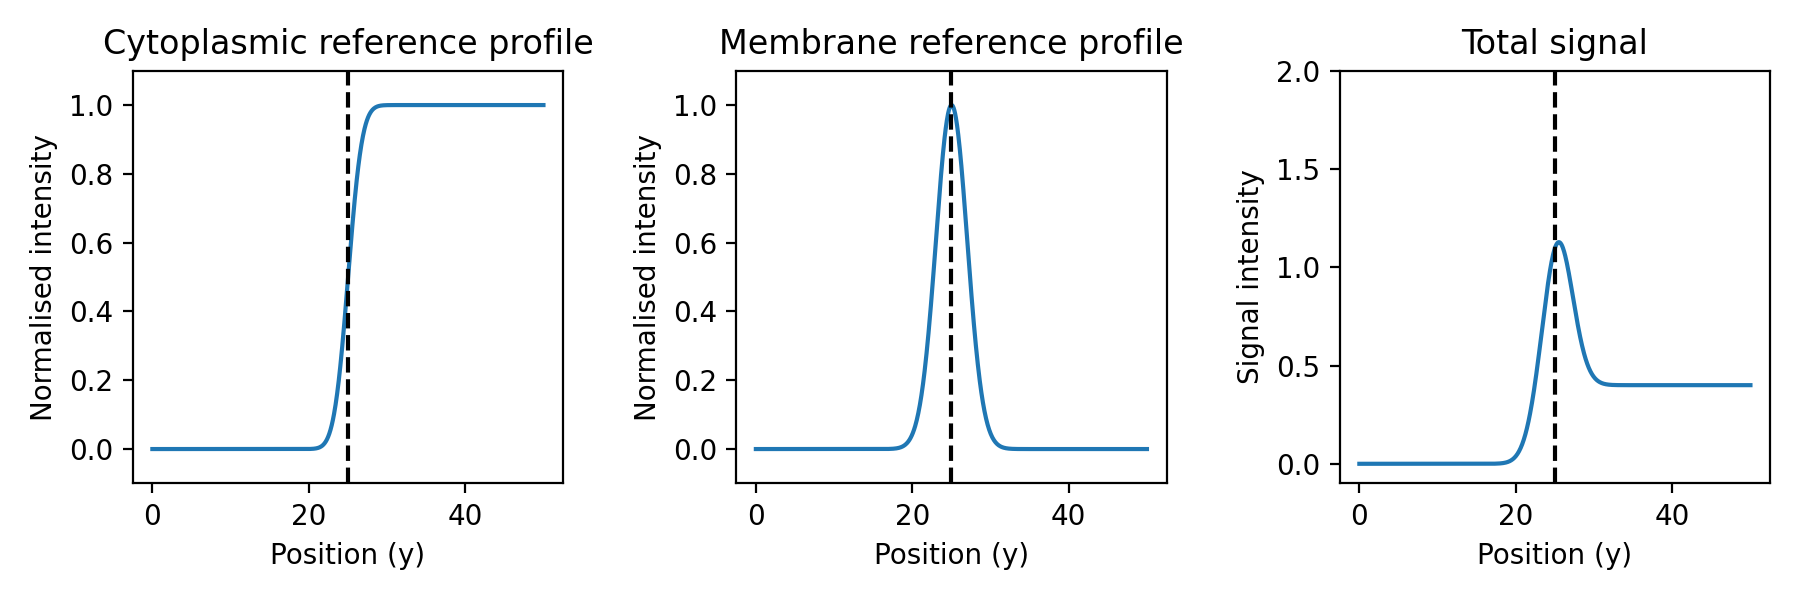

interactive(children=(IntSlider(value=3, description='sigma', max=10, min=1), FloatSlider(value=0.5, descripti…

In [3]:
from scipy.special import erf

cyt_amplitude = 1
mem_amplitude = 2
sigma = 2

def model1_fig():
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    @widgets.interact(sigma=(1, 10, 1), cyt=(0, 1, 0.1), mem=(0, 1, 0.1))
    def update(sigma=3.0, cyt=0.5, mem=0.5): 
        thickness = 50
        npoints = 1000
        cyt_profile = (1 + erf((np.arange(npoints) - npoints / 2) / (sigma * npoints/thickness))) / 2
        mem_profile = np.exp(-((np.arange(npoints) - npoints / 2) ** 2) / (2 * (sigma * npoints/thickness) ** 2))

        # Cyt profile
        ax1.clear()
        ax1.set_title('Cytoplasmic reference profile')
        ax1.plot(np.linspace(0, thickness, npoints), cyt_profile)
        ax1.axvline(thickness / 2, c='k', linestyle='--')
        ax1.set_xlabel('Position (y)')
        ax1.set_ylabel('Normalised intensity')
        ax1.set_ylim(-0.1, 1.1)

        # Mem profile
        ax2.clear()
        ax2.set_title('Membrane reference profile')
        ax2.plot(np.linspace(0, thickness, npoints), mem_profile)
        ax2.axvline(thickness / 2, c='k', linestyle='--')
        ax2.set_xlabel('Position (y)')
        ax2.set_ylabel('Normalised intensity') 
        ax2.set_ylim(-0.1, 1.1)

        # Total profile
        ax3.clear()
        ax3.set_title('Total signal')
        ax3.plot(np.linspace(0, thickness, npoints), cyt * cyt_profile + mem * mem_profile)
        ax3.axvline(thickness / 2, c='k', linestyle='--')
        ax3.set_xlabel('Position (y)')
        ax3.set_ylabel('Signal intensity')
        ax3.set_ylim(-0.1, 2)

    fig.set_size_inches(9,3)
    fig.tight_layout()
    
model1_fig()

We can see how this model can be used to quantify cytoplasmic and membrane concentrations [here.](./3_simple_model_fitting.ipynb)

(Note: cyt and mem are not in common concentration units, but rather in units of their own respective reference profiles. However, these values will be proportional to the true molar concentration, for a given sigma. Later, I will discuss a method that can be used to convert these into common units.)

## Accounting for out of focus light

A major limitation of this model is that it doesn’t account for protein above and below the focal plane, which may contribute to the midplane signal that we see. This can be significant, depending on the microscope, and must be accounted for in order to accurately quantify concentrations.

### Membrane protein

As an example, I demonstrate this phenomenon below, using a highly simplified model of a uniform membrane protein with circular geometry in the y-z plane (analagous to protein on a curved membrane) and a Gaussian point spread function. 

<IPython.core.display.Javascript object>


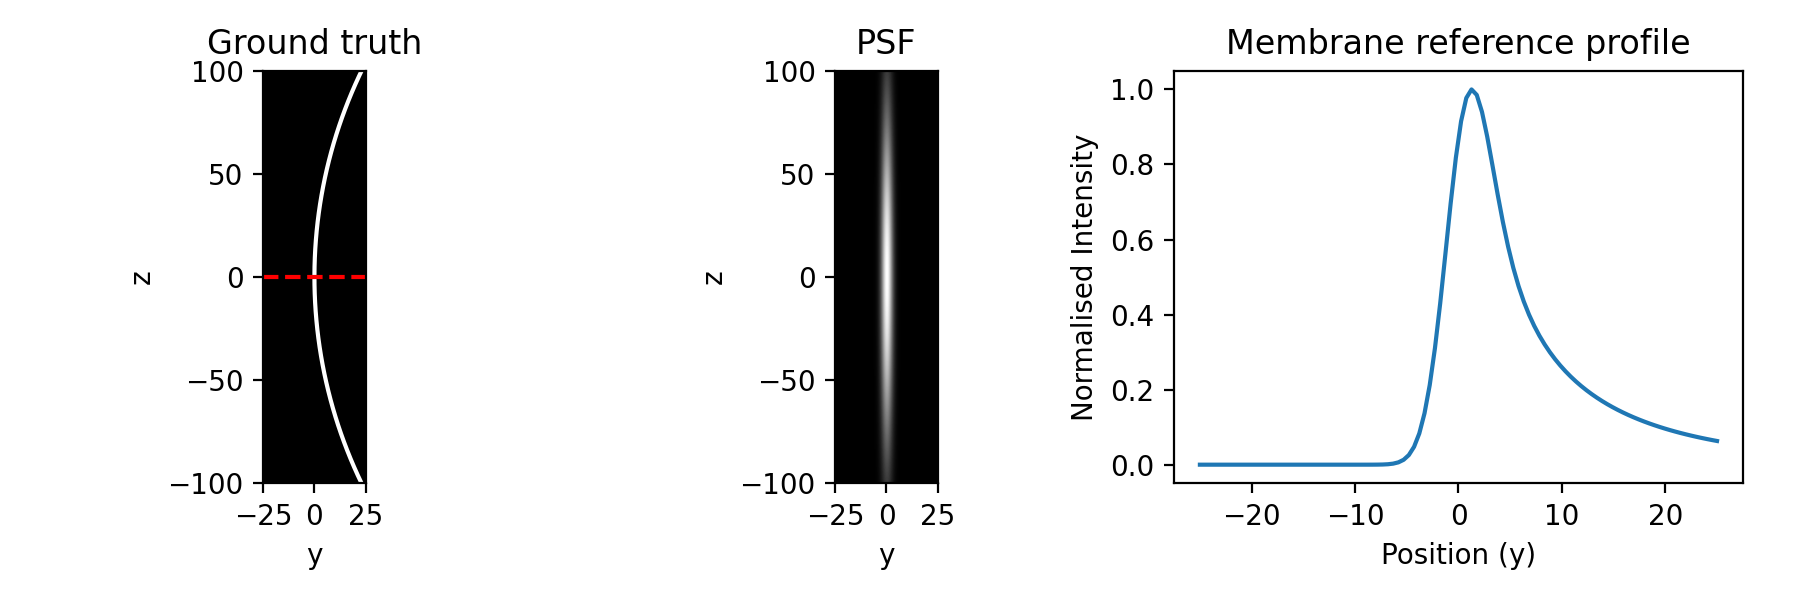

interactive(children=(IntSlider(value=2, description='sigmay', max=10, min=1), IntSlider(value=20, description…

In [7]:
from scipy.integrate import quad

ys = np.linspace(-25, 25, 1000)[:, np.newaxis]
zs = np.linspace(-100, 100, 1000)[np.newaxis, :]

def gaus2d(y, z, sigmay, sigmaz):
    return np.exp(- (((y ** 2) / (2 * (sigmay ** 2))) + ((z ** 2) / (2 * (sigmaz ** 2)))))

def boundary(theta, r):
    return r - r * np.cos(theta), r * np.sin(theta)

def mem_profile(sigmay, sigmaz, r, width, n):
    res = np.zeros([n])
    yvals = np.linspace(-width / 2, width / 2, n)
    for i, y in enumerate(yvals):
        res[i] = quad(lambda theta: gaus2d(y - r + r * np.cos(theta), r * np.sin(theta), sigmay, sigmaz), -np.pi, np.pi)[0]
    return yvals, res

def model2_fig():
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    @widgets.interact(sigmay=(1, 10, 1), sigmaz=(1, 100, 1), r=(10, 300, 10))
    def update(sigmay=2.0, sigmaz=20.0, r=100):
        
        # Ground truth
        ax1.clear()
        ax1.set_title('Ground truth')
        ax1.plot(*boundary(np.linspace(-np.pi, np.pi, 1000), r=r), c='w')
        ax1.axhline(0, c='r', linestyle='--')
        ax1.set_xlim(-25, 25)
        ax1.set_ylim(-100, 100)
        ax1.set_aspect('equal')
        ax1.set_facecolor('k')
        ax1.set_xlabel('y')
        ax1.set_ylabel('z')

        # PSF
        ax2.clear()
        ax2.set_title('PSF')
        ax2.imshow(gaus2d(ys, zs, sigmay=sigmay, sigmaz=sigmaz).T, origin='lower', extent=[-25, 25, -100, 100], aspect='equal', cmap='gray')
        ax2.set_xlabel('y')
        ax2.set_ylabel('z')

        # Midplane image
        ax3.clear()
        ax3.set_title('Membrane reference profile')
        profile_x, profile_y = mem_profile(sigmay, sigmaz, r=r, width=50, n=100)
        ax3.plot(profile_x, profile_y / max(profile_y))
        ax3.set_xlabel('Position (y)')
        ax3.set_ylabel('Normalised Intensity')

    fig.set_size_inches(9,3)
    fig.tight_layout()
    
model2_fig()

The PSF has two parameters, for sigma in the y direction (would be equal to sigma in the x direction, but we don’t need to account for this as adjacent position in the x direction are usually very similar), and sigma in the z direction (which is usually significantly higher).

As we can see, the shape of the profile depends not only on diffraction within the plane (sigma_y), but also on diffraction in the z direction (sigma_z) and geometry of the object above and below the plane (i.e. the radius of curvature in this model). If sigma_z is large and/or r is small, the membrane reference profile becomes significantly asymmetric, with a higher signal intensity within the embryo than outside. In some cases this can resemble a profile similar to what we would obtain in the 2D model with a mix of membrane and cytoplasmic protein, even though all of the protein in our model is in fact membrane bound.

### Cytoplasmic protein

We see a similar phenomenon for cytoplasmic protein. (Very laggy plot due to numerical solving, be patient!)

<IPython.core.display.Javascript object>


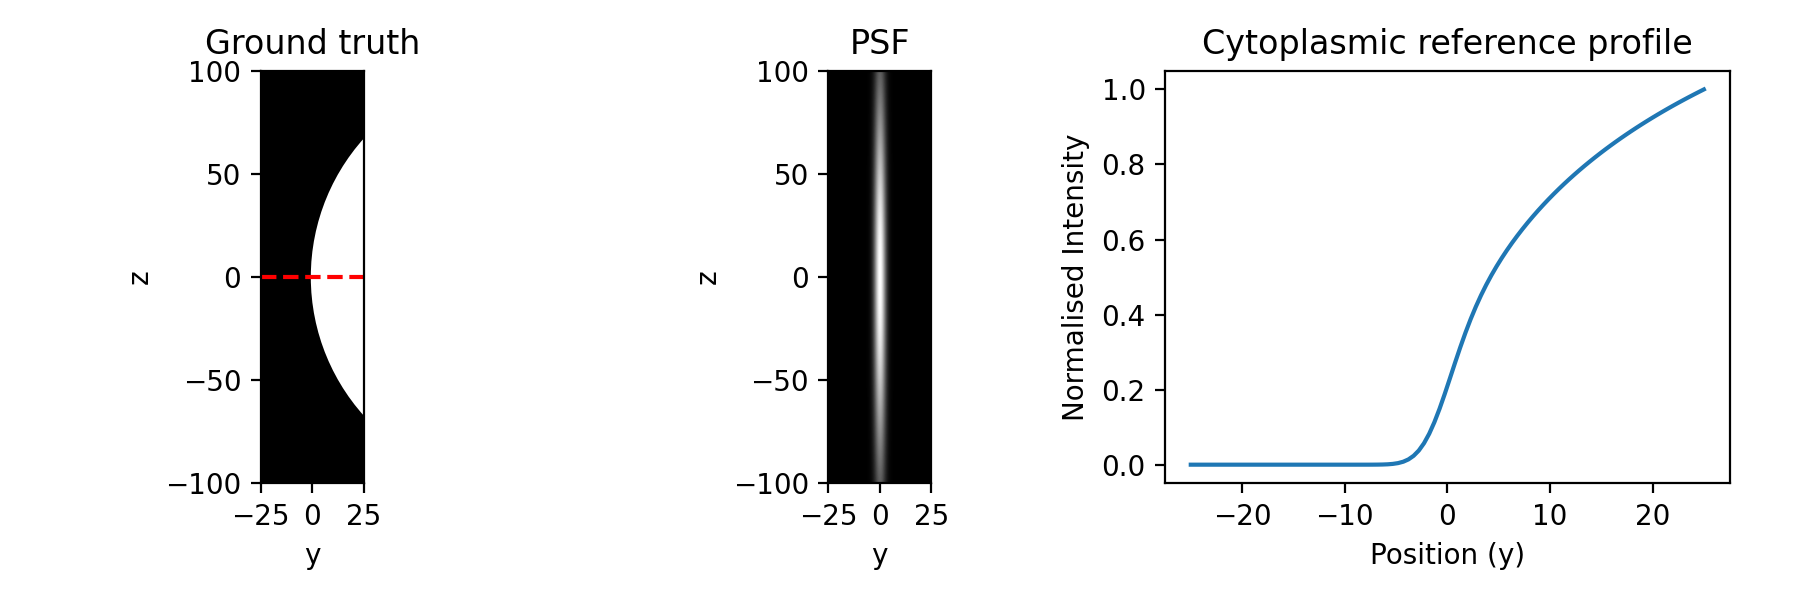

interactive(children=(IntSlider(value=2, description='sigmay', max=10, min=2), IntSlider(value=20, description…

In [5]:
from scipy.integrate import quad

ys = np.linspace(-25, 25, 1000)[:, np.newaxis]
zs = np.linspace(-100, 100, 1000)[np.newaxis, :]

def gaus2d(y, z, sigmay, sigmaz):
    return np.exp(- (((y ** 2) / (2 * (sigmay ** 2))) + ((z ** 2) / (2 * (sigmaz ** 2)))))

def cyt_profile(sigmay, sigmaz, r, width, n):
    res = np.zeros([n])
    yvals = np.linspace(-width / 2, width / 2, n)
    for i, y in enumerate(yvals):
        for j in np.linspace(0, r, n):        
            res[i] +=  j * quad(lambda theta: gaus2d(y - 2 * r + j + j * np.cos(theta), j * np.sin(theta), sigmay, sigmaz), -np.pi, np.pi)[0]
    return yvals, res

def model2_fig():
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    @widgets.interact(sigmay=(2, 10, 1), sigmaz=(1, 100, 1), r=(10, 200, 10))
    def update(sigmay=2.0, sigmaz=20.0, r=100):

        # Ground truth
        ax1.clear()
        ax1.set_title('Ground truth')
        circle = plt.Circle((r, 0), r, color='w')
        ax1.add_patch(circle)
        ax1.axhline(0, c='r', linestyle='--')
        ax1.set_xlim(-25, 25)
        ax1.set_ylim(-100, 100)
        ax1.set_aspect('equal')
        ax1.set_facecolor('k')
        ax1.set_xlabel('y')
        ax1.set_ylabel('z')
        
        # PSF
        ax2.clear()
        ax2.set_title('PSF')
        ax2.imshow(gaus2d(ys, zs, sigmay=sigmay, sigmaz=sigmaz).T, origin='lower', extent=[-25, 25, -100, 100], aspect='equal', cmap='gray')
        ax2.set_xlabel('y')
        ax2.set_ylabel('z')

        # Midplane image
        ax3.clear()
        ax3.set_title('Cytoplasmic reference profile')
        profile_x, profile_y = cyt_profile(sigmay, sigmaz, r=r, width=50, n=100)
        ax3.plot(profile_x, profile_y / max(profile_y))
        ax3.set_xlabel('Position (y)')
        ax3.set_ylabel('Normalised Intensity')

    fig.set_size_inches(9,3)
    fig.tight_layout()
    
model2_fig()

In some cases, we can see intensity of this profile increase beyond the cell boundary as we go further into the cell, due to an increse in cell thicknesss. As before, this depends on sigmaz and r

## Discussion

If accuracy is not essential, then the simple 2D model is an easy and intuitive model to use, and makes few assumptions. However, as the simulations above demonstrate, we may need to account for 3D effects in order to accurately quantify membrane and cytoplasmic concentrations (depending on geometry and the 3D PSF in our set-up)

The models above makes strong assumptions about geometry and the PSF, and are only intended as toy models to demonstrate the effects that out of focus light can have on our observations of cytoplasmic and membrane protein. In reality, the geometry of our sample above and below the plane is unpredictable, and may depend on the method of sample preparation (agarose vs beads, size of beads). True PSFs in confocal systems also tend to deviate significantly from Gaussian in 3D, and will vary depending on the microscope setup and, optical properties of the sample, and imaging depth. Tools do exist that allow the point spread function to be estimated based on microscope and sample parameters, but they are not good enough to be relied upon for accurate models. 

For these reasons, we cannot build a comprehensive model that accurately describes geometry and z-direction scattering from first principles. However, regardless of the underlying processes, we can at least assume that the resulting reference profiles for membrane and cytoplasmic protein should have a constant normalised shape, for the following reasons:
-	local geometry is roughly uniform (i.e. uniform membrane curvature). There may be small variations between the midcell and pole, but these are likely minor (I look into this [here](./control_profile_spatial_variation.ipynb))
- at a local level, cytoplasmic and membrane concentrations can usually be considered uniform in the x, y and z directions (except at polarity domain boundaries, where this assumption will break down somewhat)
-	the PSF can be assumed constant throughout the image in the x-y plane, and is likely small enough that we only need to consider local geometry and concentrations (i.e. a profile at the anterior pole will not be influence by protein at the posterior pole)
- we will be imaging all embryos with the same microscope set-up
- we will take all midplane images at roughly the same depth

Thus, regardless of the underlying mechanics, in order to quantify local cytoplasmic and membrane concentrations based on cross-cortex profiles, we just need to know the shape of the two reference profiles for membrane and cytoplasmic protein specific to our set-up, and then fit measured profiles to a two-component model based on these profiles (as above for the 2D model).

The derivation of these two reference profiles is the subject of discussion in [this notebook](./4_custom_model.ipynb)